# Mapping Mortality: Predicting Cancer Death Rates Across America

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

## Exploratory Data Analysis

### Loading Dataset

In [74]:
df_cancer = pd.read_csv("C:/Users/Hyunseok/Downloads/cancer_reg.csv")
df_household = pd.read_csv("C:/Users/Hyunseok/Downloads/avg-household-size.csv")

print(df_cancer.head())
print(df_cancer.shape)
print(df_household.shape)
print(df_cancer.info())
print(df_cancer.isna().sum()) # Some large NAs in 'pctsomecol'
print(df_household.isna().sum()) # No NAs

   avganncount  avgdeathsperyear  target_deathrate  incidencerate  medincome  \
0       1397.0               469             164.9          489.8      61898   
1        173.0                70             161.3          411.6      48127   
2        102.0                50             174.7          349.7      49348   
3        427.0               202             194.8          430.4      44243   
4         57.0                26             144.4          350.1      49955   

   popest2015  povertypercent  studypercap           binnedinc  medianage  \
0      260131            11.2   499.748204   (61494.5, 125635]       39.3   
1       43269            18.6    23.111234  (48021.6, 51046.4]       33.0   
2       21026            14.6    47.560164  (48021.6, 51046.4]       45.0   
3       75882            17.1   342.637253    (42724.4, 45201]       42.8   
4       10321            12.5     0.000000  (48021.6, 51046.4]       48.3   

   ...  pctprivatecoveragealone  pctempprivcoverage pctp

### Dataset Summary
Number of rows: 3,047

Number of columns: 33

Data types:

28 float64

3 int64

2 object (binnedinc, geography)

Missing values:
Columns like pctsomecol18_24, pctemployed16_over, and pctprivatecoveragealone have a significant number of missing values.
The rest of the columns are mostly complete.

In [75]:
# Check unique values and their frequencies
print(df_cancer['binnedinc'].value_counts())
print(df_cancer['geography'].value_counts())

binnedinc
(54545.6, 61494.5]    306
[22640, 34218.1]      306
(45201, 48021.6]      306
(48021.6, 51046.4]    305
(42724.4, 45201]      305
(51046.4, 54545.6]    305
(37413.8, 40362.7]    304
(40362.7, 42724.4]    304
(34218.1, 37413.8]    304
(61494.5, 125635]     302
Name: count, dtype: int64
geography
Kitsap County, Washington            1
Ralls County, Missouri               1
Pemiscot County, Missouri            1
Perry County, Missouri               1
Pettis County, Missouri              1
                                    ..
San Bernardino County, California    1
Cullman County, Alabama              1
San Diego County, California         1
San Francisco County, California     1
Geary County, Kansas                 1
Name: count, Length: 3047, dtype: int64


In [76]:
# Create ordinal mapping based on apparent order of ranges
binnedinc_mapping = {
    '(22640, 34218.1]': 1,
    '(34218.1, 37413.8]': 2,
    '(37413.8, 40362.7]': 3,
    '(40362.7, 42724.4]': 4,
    '(42724.4, 45201]': 5,
    '(45201, 48021.6]': 6,
    '(48021.6, 51046.4]': 7,
    '(51046.4, 54545.6]': 8,
    '(54545.6, 61494.5]': 9,
    '(61494.5, 125635]': 10
}
df_cancer['binnedinc_encoded'] = df_cancer['binnedinc'].map(binnedinc_mapping)
df_cancer['state'] = df_cancer['geography'].apply(lambda x: x.split(', ')[-1])

### Avg_household_size

In [77]:
print(df_household.head())
print(df_household.info())
df_household['state'] = df_household['geography'].apply(lambda x: x.split(', ')[-1])


   statefips  countyfips  avghouseholdsize                           geography
0          2          13              2.43      Aleutians East Borough, Alaska
1          2          16              3.59  Aleutians West Census Area, Alaska
2          2          20              2.77      Anchorage Municipality, Alaska
3          2          50              3.86          Bethel Census Area, Alaska
4          2          60              2.50         Bristol Bay Borough, Alaska
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   statefips         3220 non-null   int64  
 1   countyfips        3220 non-null   int64  
 2   avghouseholdsize  3220 non-null   float64
 3   geography         3220 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 100.8+ KB
None


### Merge dataset

In [78]:
# Merging the two datasets on the state column
merged_df = pd.merge(df_cancer, df_household, on='geography', how='left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avganncount              3047 non-null   float64
 1   avgdeathsperyear         3047 non-null   int64  
 2   target_deathrate         3047 non-null   float64
 3   incidencerate            3047 non-null   float64
 4   medincome                3047 non-null   int64  
 5   popest2015               3047 non-null   int64  
 6   povertypercent           3047 non-null   float64
 7   studypercap              3047 non-null   float64
 8   binnedinc                3047 non-null   object 
 9   medianage                3047 non-null   float64
 10  medianagemale            3047 non-null   float64
 11  medianagefemale          3047 non-null   float64
 12  geography                3047 non-null   object 
 13  percentmarried           3047 non-null   float64
 14  pctnohs18_24            

### Label Encoding

In [79]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to 'state' column
merged_df['geography_encoded'] = label_encoder.fit_transform(merged_df['geography'])

# Display the first few rows to check the mapping
print(merged_df[['geography', 'geography_encoded']].head())

merged_df = merged_df.drop(columns=['geography' , 'binnedinc'])

# inference_data['state'] = label_encoder.inverse_transform(inference_data['state_encoded'])

# Now, the 'state' column will contain the original state names (strings)

                      geography  geography_encoded
0     Kitsap County, Washington               1458
1   Kittitas County, Washington               1459
2  Klickitat County, Washington               1463
3      Lewis County, Washington               1587
4    Lincoln County, Washington               1617


1. avganncount and avgdeathsperyear:

Mean: Both have relatively high averages (606 and 186, respectively).

Range: avganncount goes up to 38,150, indicating a significant variation in annual cancer case counts.

Skewness: The large difference between the mean (606) and max (38,150) suggests the distribution is likely skewed with some high outliers.

2. target_deathrate:This is likely the dependent variable in your regression analysis.

Mean: 178.66, with a relatively narrow range compared to other columns (59.7–362.8).

Insights: Indicates that while death rates vary, extreme outliers are less prominent.

3. incidencerate:

Cancer incidence rates have a mean of 448.27, with a maximum of 1,206.9.
The difference between the 25th percentile (420.3) and 75th percentile (480.85) suggests most regions have a moderate variation, while the max is a clear outlier.

4. Demographics:

povertypercent: Ranges from 3.2% to 47.4%, with an average of 16.88%. Regions with high poverty might show a correlation with higher death rates.

medianage, medianagemale, medianagefemale:
Median age varies significantly (22.3 to 624!). This is likely an anomaly (outlier) that needs addressing.

birthrate:
Moderate variation (mean = 5.64, range = 0 to 21.33). High values may correspond to younger populations, which could correlate with certain cancer statistics.

5. Insurance and Employment:

pctemployed16_over: Missing 152 values; median is high (~54%), but the range (13.5–78.9%) shows variation in employment across regions.

pctprivatecoverage and pctpubliccoverage:
Moderate variation in access to private and public coverage (e.g., private: 11.2–65.1%).
Missing values in pctprivatecoveragealone suggest incomplete insurance data.

6. Race and Ethnicity:

pctwhite, pctblack, pctasian, pctotherrace:
pctwhite dominates (mean = 83.65%), while pctblack and others have lower means. This may affect correlations with healthcare access or outcomes.

7. Potential Outliers:

Features like avganncount, medianage, studypercap, and birthrate show extreme max values compared to their means.
These outliers might heavily influence the regression model and should be visualized and potentially transformed or capped.

### Boxplot for outlier detection

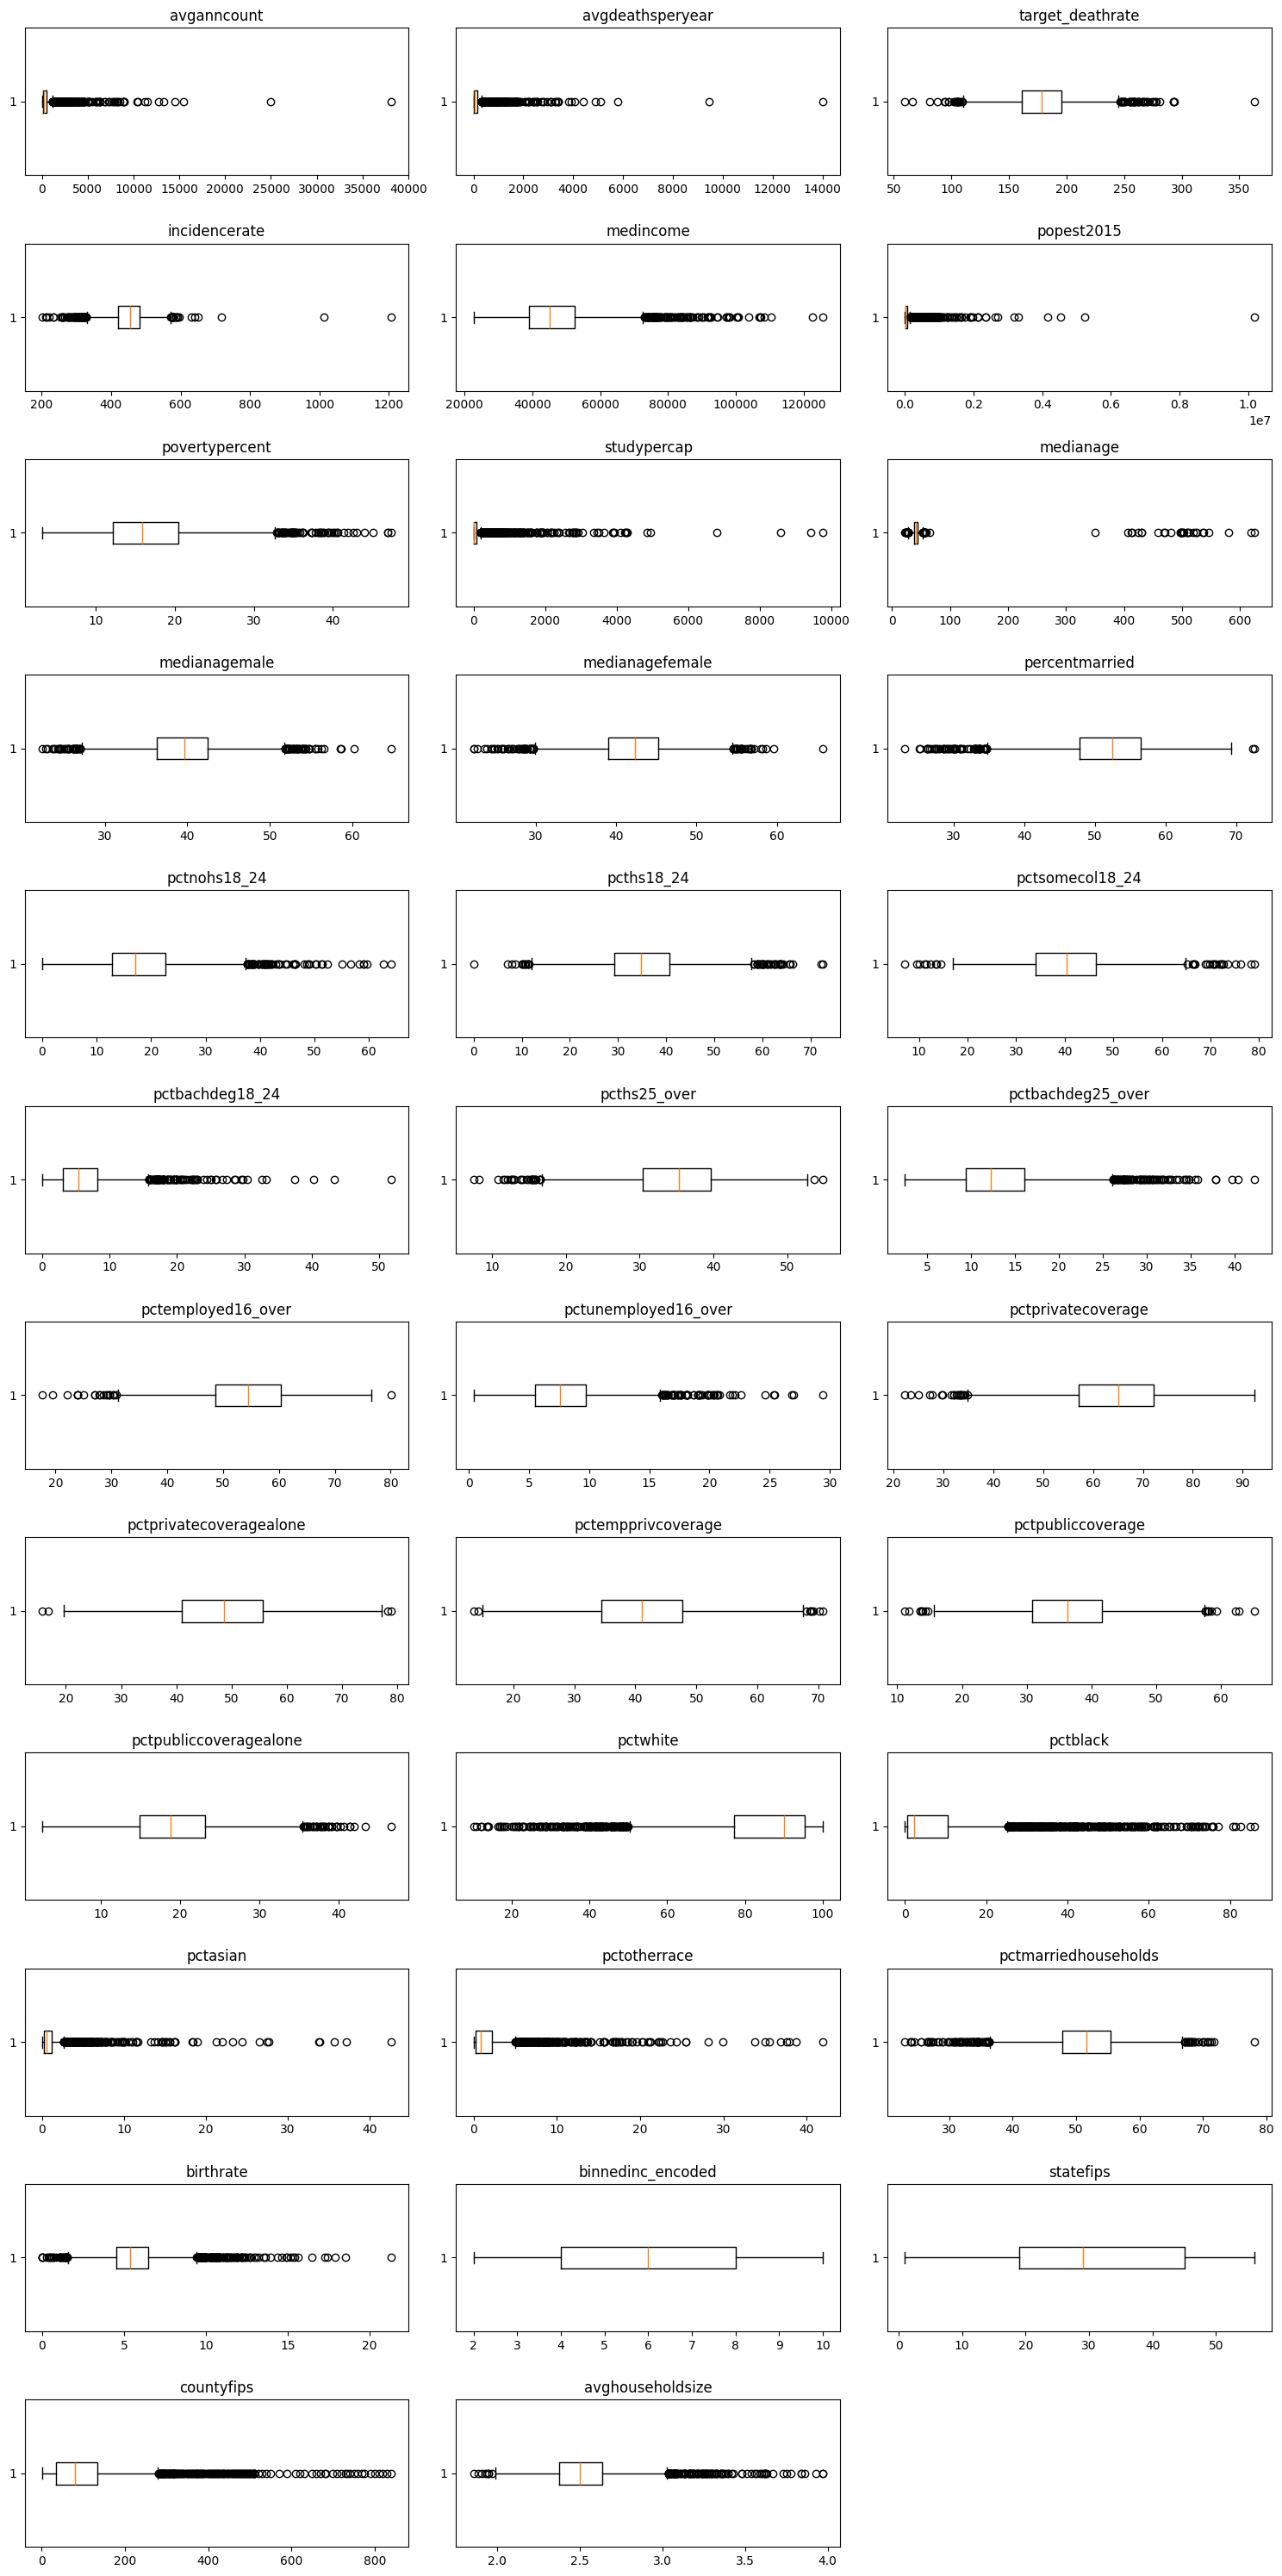

In [80]:
# Select only numeric columns for boxplot visualization
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns

# Create boxplots for all numeric columns to detect outliers
fig, axes = plt.subplots(nrows=len(numeric_columns)//3 + 1, ncols=3, figsize=(15, 30))
axes = axes.flatten()

for idx, column in enumerate(numeric_columns):
    ax = axes[idx]
    ax.boxplot(merged_df[column].dropna(), vert=False)
    ax.set_title(column)

# Hide unused subplots if any
for idx in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [81]:
# Function to handle outliers
def cap_outliers(series, method='median'):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Cap values beyond the bounds
    if method == 'mean':
        fill_value = series.mean()
    else:  # Default to median
        fill_value = series.median()
    
    series = series.clip(lower=lower_bound, upper=upper_bound)
    return series.fillna(fill_value)

# Apply imputation for numeric columns
for column in numeric_columns:
    merged_df[column] = cap_outliers(merged_df[column], method='mean')  # Choose 'mean' or 'median' as needed

# For non-numeric columns with NA values, fill with mode
non_numeric_columns = merged_df.select_dtypes(include=['object']).columns
for column in non_numeric_columns:
    merged_df[column] = merged_df[column].fillna(merged_df[column].mode()[0])

### Correlation Matrix

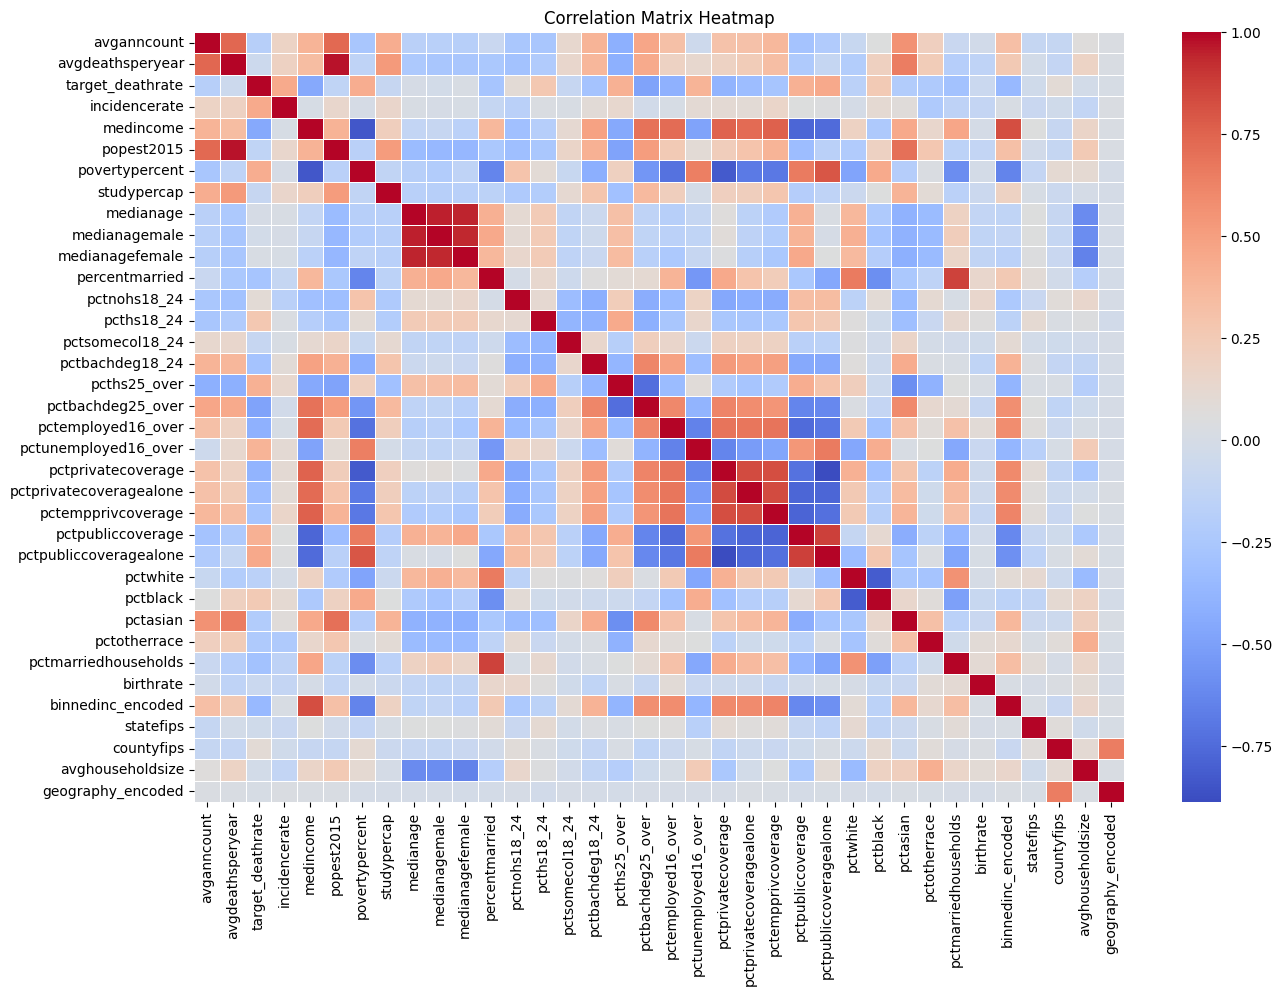

In [82]:
# Calculate the correlation matrix
merged_df = merged_df.drop(columns=['state_x' , 'state_y'])

correlation_matrix = merged_df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [83]:
# High correlation
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Remove self-correlations (correlation of a variable with itself)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]

# Display only pairs with an absolute correlation above a threshold (e.g., 0.9)
threshold = 0.9
high_corr_pairs = high_corr_pairs[abs(high_corr_pairs) > threshold]
print(high_corr_pairs)

avgdeathsperyear  popest2015          0.974413
popest2015        avgdeathsperyear    0.974413
medianagemale     medianage           0.951907
medianage         medianagemale       0.951907
medianagefemale   medianage           0.945210
medianage         medianagefemale     0.945210
medianagefemale   medianagemale       0.934602
medianagemale     medianagefemale     0.934602
dtype: float64


### Finding if the target variable is correlated between other variables

In [84]:
corr_matrix = merged_df.corr()

# Get the correlation of the specific column with all other columns
target_column = "target_deathrate"  
corr_with_target = corr_matrix[target_column].drop(target_column)

# Filter the correlations above or below the threshold (taking a threshold value of 0.5)
threshold = 0.5
high_corr_with_target = corr_with_target[abs(corr_with_target) > threshold]

print(high_corr_with_target)

Series([], Name: target_deathrate, dtype: float64)


From the above code, we find that the target property: experimental_proprty is not correlated between the other variables with the threshold of 0.5.

That is, the target property is not linearly dependent on any of the other variables in the dataset. We can also verify this with the PCA dimension reduction method below.

###  Top 10 features relate to target_deathrate

In [85]:
# Select only numeric columns for calculating correlations
numeric_data = merged_df.select_dtypes(include=[np.number])
# Make Correlation between numerical data
correlation_matrix = numeric_data.corr()
# Sort values
correlations_target_rate = correlation_matrix['target_deathrate'].abs().sort_values(ascending=False)
# Get top 10 features relate to 'target_deathrate'
top10_features = correlations_target_rate.head(10)

print(f"Top 10 features most correlated with target_deathrate: {top10_features}")

Top 10 features most correlated with target_deathrate: target_deathrate          1.000000
pctbachdeg25_over         0.486907
pctpubliccoveragealone    0.451206
incidencerate             0.446887
medincome                 0.445299
povertypercent            0.429539
pcths25_over              0.410121
pctpubliccoverage         0.408515
pctemployed16_over        0.401822
pctprivatecoverage        0.393039
Name: target_deathrate, dtype: float64


In [87]:
merged_df.head()

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,...,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate,binnedinc_encoded,statefips,countyfips,avghouseholdsize,geography_encoded
0,1181.0,330.5,164.9,489.8,61898.0,154151.5,11.2,209.126941,39.3,36.9,...,2.594728,2.671295,1.843479,52.856076,6.118831,10.0,53,35,2.54,1458
1,173.0,70.0,161.3,411.6,48127.0,43269.0,18.6,23.111234,33.0,32.2,...,0.969102,2.246233,3.741352,45.372500,4.333096,7.0,53,37,2.34,1459
2,102.0,50.0,174.7,349.7,49348.0,21026.0,14.6,47.560164,45.0,44.0,...,0.739673,0.465898,2.747358,54.444868,3.729488,7.0,53,39,2.62,1463
3,427.0,202.0,194.8,430.4,44243.0,75882.0,17.1,209.126941,42.8,42.2,...,0.782626,1.161359,1.362643,51.021514,4.603841,5.0,53,41,2.52,1587
4,57.0,26.0,144.4,350.1,49955.0,10321.0,12.5,0.000000,48.3,47.8,...,0.270192,0.665830,0.492135,54.027460,6.796657,7.0,53,43,2.34,1617


### Select Key Columns 

In [88]:
# Select only key feature columns
## Since most of population are highly skewed in White so didn't include any other features
key_columns = [
    'target_deathrate', # Target death rate due to cancer.
    'avganncount', # Average number of cancer cases diagnosed annually.
    'avgdeathsperyear', # Average number of deaths due to cancer per year.
    'incidencerate', # Incidence rate of cancer.
    'medincome', # Median income in the region.
    'povertypercent', # Percentage of population below the poverty line.
    'pctprivatecoverage', # Percentage of population covered by private health insurance 
    'pctpubliccoverage', # Percentage of population covered by public health insurance.
    'birthrate', # Birth rate in the region.
    'pctmarriedhouseholds', #  Percentage of married households.
    'avghouseholdsize', # Average householdsize
    'geography_encoded' # geography data 
]


# Standard Scaler
scaler = StandardScaler()

x = merged_df[key_columns].drop(columns=['target_deathrate'])
y = merged_df['target_deathrate']

# Split training and test dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


## Model Selection

### Linear Regression

In [89]:
# Build Linear model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

y_pred = lr_model.predict(x_test)

# R^2 value comparison
mse_lr = mean_squared_error(y_test,y_pred)
rmse_lr = (mse_lr)**(1/2)
r2_lr = r2_score(y_test, y_pred)
print(f'rmse: {round(rmse_lr, 4)}')
print(f'R-squared: {round(r2_lr,4)}')

rmse: 20.3676
R-squared: 0.455


#### Grid Search for Lasso linear model

In [90]:
lasso = Lasso(random_state=42)

lasso_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Perform Lasso grid search
grid_lasso = GridSearchCV(
    estimator=lasso,
    param_grid=lasso_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=2
)

grid_lasso.fit(x_train, y_train)

# Best parameters and score
best_lasso_params = grid_lasso.best_params_
best_lasso_score = grid_lasso.best_score_

print(f'Best train parameter: {best_lasso_params}')
print(f'Best train score(R^2) : {round(best_lasso_score,4)}')

# Evlauate Lasso model
y_pred_lasso = grid_lasso.predict(x_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = (mse_lasso)**(1/2)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"test R²: {r2_lasso:.4f}")
print(f"test RMSE: {rmse_lasso:.4f}")



Best train parameter: {'alpha': 0.1}
Best train score(R^2) : 0.4291
test R²: 0.4549
test RMSE: 20.3699


#### Grid Search for Ridge Linear model

In [91]:
ridge = Ridge(random_state=42)

# Set Hyperparameters
ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=ridge_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=2
)

# Best parameters and score
grid_ridge.fit(x_train, y_train)

best_ridge_params = grid_ridge.best_params_
best_ridge_score = grid_ridge.best_score_

print(f'Best train parameter: {best_ridge_params}')
print(f'Best train score(R^2) : {round(best_ridge_score,4)}')

# Evlauate Ridge model
y_pred_ridge = grid_ridge.predict(x_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = (mse_ridge)**(1/2)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"test R²: {r2_ridge:.4f}")
print(f"test RMSE: {rmse_ridge:.4f}")


Best train parameter: {'alpha': 10}
Best train score(R^2) : 0.4284
test R²: 0.4555
test RMSE: 20.3577


### Regression Tree

In [92]:
dt = DecisionTreeRegressor(random_state=42)
dt_param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_dt = GridSearchCV(
    estimator=dt, 
    param_grid=dt_param_grid, 
    cv=5, 
    scoring='r2',
    n_jobs= 2,
    verbose= 1
    )
grid_dt.fit(x_train, y_train)

print("Best train parameters:", grid_dt.best_params_)
print("Best train R²:", round(grid_dt.best_score_,4))

# Predict test value
y_pred_dt = grid_dt.predict(x_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = (mse_dt)**(1/2)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"test R²: {r2_dt:.5f}")
print(f"test RMSE: {rmse_dt:.5f}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best train parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best train R²: 0.3358
test R²: 0.42208
test RMSE: 20.97369


### Random Forest

In [ ]:
rfregressor = RandomForestRegressor(random_state = 42)

# Set hyperparameters
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(
    rfregressor, 
    param_distributions=rf_param_grid, 
    n_iter=10, 
    cv=5, 
    scoring='r2',  
    random_state= 42,
    n_jobs=2,
    verbose = 1
)
random_search_rf.fit(x_train, y_train)

print("Best train parameters:", random_search_rf.best_params_)
print('train r2 score: ', round(random_search_rf.best_score_, 4))

# Predict model
y_pred_rf = random_search_rf.predict(x_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = (mse_rf)**(1/2)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"test R²: {r2_rf:.5f}")
print(f"test MSE: {rmse_rf:.5f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
train r2 score:  0.4868
test R²: 0.53815
test MSE: 18.74970


#### PLS

In [ ]:
from sklearn.cross_decomposition import PLSRegression
# Define the parameter
parameters = {'n_components':np.arange(1,10,1)}
# grid-search  PLS regression
grid_pls = GridSearchCV(PLSRegression(), 
                   parameters, 
                   scoring = 'neg_mean_squared_error', 
                   verbose=0, 
                   cv=5,
                   n_jobs=2)
# Fit the estimator to the data
grid_pls.fit(x_train, y_train)

print("Best train parameters:", grid_pls.best_params_)
print('train r2 score: ', round(grid_pls.best_score_, 4))

# Predict model
y_pred_pls = grid_pls.predict(x_test)
mse_pls = mean_squared_error(y_test, y_pred_pls)
rmse_pls = (mse_pls)**(1/2)
r2_pls = r2_score(y_test, y_pred_pls)

print(f"test R²: {r2_pls:.5f}")
print(f"test MSE: {rmse_pls:.5f}")


Best train parameters: {'n_components': 7}
train r2 score:  -397.9005
test R²: 0.45535
test MSE: 20.36101


#### XGBoost regression

In [ ]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(random_state=42)
# Define paramater grid
xgb_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.6, 1.0]
}
# Define grid search for xgboost model
grid_xgb = GridSearchCV(
    estimator=xgb_reg,
    param_grid=xgb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=2,
    verbose=3
)
# Fit model
grid_xgb.fit(x_train, y_train)
print("Best train parameters:", grid_xgb.best_params_)
print('train r2 score: ', round(grid_xgb.best_score_, 4))

# predict model
y_pred_xgb = grid_xgb.predict(x_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = (mse_xgb)**(1/2)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"test R²: {r2_xgb:.5f}")
print(f"test MSE: {rmse_xgb:.5f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
test R²: 0.70747
test MSE: 14.92193


###  Finalized model

               Model        R²         MSE       RMSE
0  Linear Regression  0.455002  414.838766  20.367591
1   Lasso Regression  0.454879  414.932274  20.369886
2   Ridge Regression  0.455530  414.437143  20.357729
3      Decision Tree  0.422083  439.895583  20.973688
4      Random Forest  0.538146  351.551242  18.749700
5                PLS  0.455354  414.570791  20.361012
6            XGBoost  0.707473  222.664121  14.921934


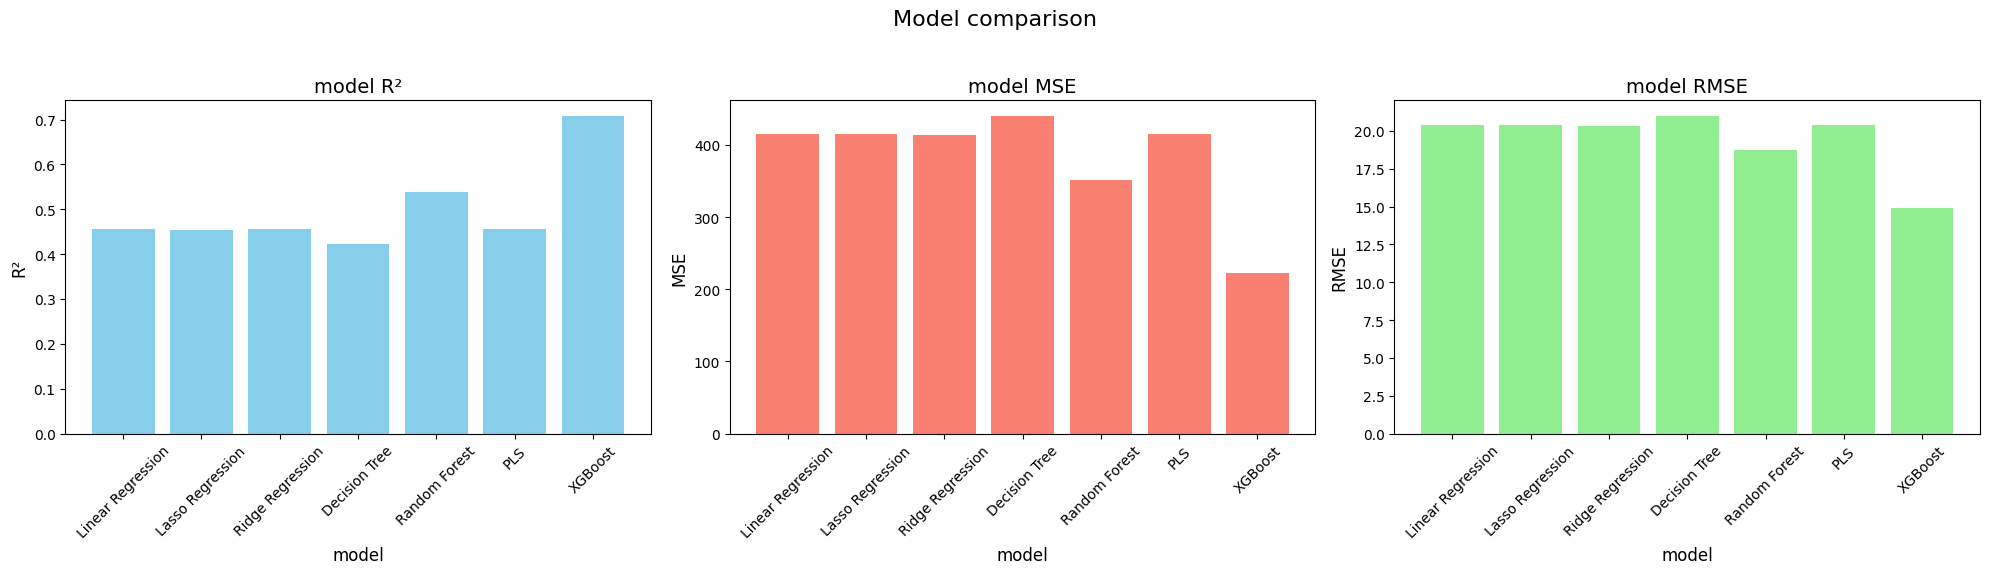

In [ ]:
model_performance = pd.DataFrame({
    'Model': ['Linear Regression','Lasso Regression', 'Ridge Regression', 'Decision Tree', 'Random Forest', 'PLS', 'XGBoost'],
    'R²': [r2_lr ,r2_lasso, r2_ridge, r2_dt, r2_rf, r2_pls, r2_xgb],
    'MSE': [mse_lr, mse_lasso, mse_ridge, mse_dt, mse_rf, mse_pls, mse_xgb],
    'RMSE': [rmse_lr, rmse_lasso, rmse_ridge, rmse_dt, rmse_rf, rmse_pls, rmse_xgb]
})
print(model_performance)
# Best model : XGBoost 

# Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# R² graph
axes[0].bar(model_performance['Model'], model_performance['R²'], color='skyblue')
axes[0].set_title('model R²', fontsize=14)
axes[0].set_xlabel('model', fontsize=12)
axes[0].set_ylabel('R²', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# MSE graph
axes[1].bar(model_performance['Model'], model_performance['MSE'], color='salmon')
axes[1].set_title('model MSE', fontsize=14)
axes[1].set_xlabel('model', fontsize=12)
axes[1].set_ylabel('MSE', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# RMSE graph
axes[2].bar(model_performance['Model'], model_performance['RMSE'], color='lightgreen')
axes[2].set_title('model RMSE', fontsize=14)
axes[2].set_xlabel('model', fontsize=12)
axes[2].set_ylabel('RMSE', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

# Comparison
plt.suptitle('Model comparison', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Write up